# Scientific Paper

The model architecture in this notebook was based on the paper Deep residual networks for image recognition by He et al. (2015). 

See the paper for more details : https://arxiv.org/abs/1512.03385   

<img src="images/ResNet.png" style="width:1000px;height:200px;">  

Note : I made some slight modifications to the original architectures, for instance I used a more powerful skip of 3 connections instead of 2. These modifications are based on Andrew Ng recommendations from his Deep Learning: Convolutional Neural Networks course.

# Dependencies

In [1]:
!conda env create -f environment.yml


CondaValueError: prefix already exists: /home/user/miniconda3/envs/resnet



In [2]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

from tqdm import tqdm
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor

%matplotlib inline
torch.manual_seed(0)

# Data

In [3]:
IMAGE_SIZE=64

## Preprocessing

In [4]:
preprocessing = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
    transforms.ToTensor(),
    Normalize(mean=(0.5), std=(0.5))
])

## Datasets

In [5]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=preprocessing)

/home/user/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
test_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=preprocessing)

## Visualization

In [7]:
def show_data_gray(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

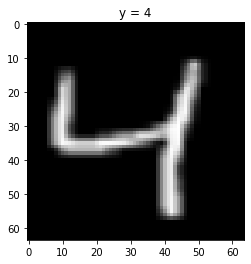

In [8]:
show_data_gray(train_dataset[2])

# Model Definition

In [9]:
class ResNet50(nn.Module):
    """Forward expects inputs of size (m, C, H, W)"""
    
    def __init__(self, in_channels, classes=6):
        super(ResNet50, self).__init__()
        
        self.pad = nn.ZeroPad2d((3,3))
        
        self.stage_1_conv2d = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding='valid')
        self.stage_1_batchnorm = nn.BatchNorm2d(num_features=64)
        self.stage_1_activation = nn.ReLU()
        self.stage_1_pooling = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2))
        
        self.stage_2_conv_block = self.get_convolutional_block(in_channels=64, f=3, filters=[64, 64, 256], s=1)
        self.stage_2_id_block_1 = self.get_identity_block(in_channels=256, f=3, filters=[64, 64, 256])
        self.stage_2_id_block_2 = self.get_identity_block(in_channels=256, f=3, filters=[64, 64, 256])
        
        self.stage_3_conv_block = self.get_convolutional_block(in_channels=256, f=3, filters=[128, 128, 512], s=2)
        self.stage_3_id_block_1 = self.get_identity_block(in_channels=512, f=3, filters=[128, 128, 512])
        self.stage_3_id_block_2 = self.get_identity_block(in_channels=512, f=3, filters=[128, 128, 512])
        
        self.stage_4_conv_block = self.get_convolutional_block(in_channels=512, f=3, filters=[256, 256, 1024], s=2)
        self.stage_4_id_block_1 = self.get_identity_block(in_channels=1024, f=3, filters=[256, 256, 1024])
        self.stage_4_id_block_2 = self.get_identity_block(in_channels=1024, f=3, filters=[256, 256, 1024])
        self.stage_4_id_block_3 = self.get_identity_block(in_channels=1024, f=3, filters=[256, 256, 1024])
        self.stage_4_id_block_4 = self.get_identity_block(in_channels=1024, f=3, filters=[256, 256, 1024])
        self.stage_4_id_block_5 = self.get_identity_block(in_channels=1024, f=3, filters=[256, 256, 1024])
        
        self.stage_5_conv_block = self.get_convolutional_block(in_channels=1024, f=3, filters=[512, 512, 2048], s=2)
        self.stage_5_id_block_1 = self.get_identity_block(in_channels=2048, f=3, filters=[512, 512, 2048])
        self.stage_5_id_block_2 = self.get_identity_block(in_channels=2048, f=3, filters=[512, 512, 2048])
        
        self.avg_pool = nn.AvgPool2d(kernel_size=(2,2))
        
        self.flat = nn.Flatten()
        
        self.fc = nn.Linear(2048, classes)
    
    def get_identity_block(self, in_channels, f, filters):
        
        block = nn.ModuleList()
        
        F1, F2, F3 = filters
        
        block.append(nn.Conv2d(in_channels=in_channels, out_channels=F1, kernel_size=(1,1), stride=(1,1), padding='valid'))
        block.append(nn.BatchNorm2d(num_features=F1))
        block.append(nn.ReLU())
        
        block.append(nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=(f,f), stride=(1,1), padding='same'))
        block.append(nn.BatchNorm2d(num_features=F2))
        block.append(nn.ReLU())
        
        block.append(nn.Conv2d(in_channels=F2, out_channels=F3, kernel_size=(1,1), stride=(1,1), padding='valid'))
        block.append(nn.BatchNorm2d(num_features=F3))
        
        block.append(nn.ReLU())
        
        return block
    
    
    def get_convolutional_block(self, in_channels, f, filters, s=2):
        
        block = nn.ModuleList()
        
        F1, F2, F3 = filters
        
        block.append(nn.Conv2d(in_channels=in_channels, out_channels=F1, kernel_size=(1,1), stride=(s,s), padding='valid'))
        block.append(nn.BatchNorm2d(num_features=F1))
        block.append(nn.ReLU())

        
        block.append(nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=(f,f), stride=(1,1), padding='same'))
        block.append(nn.BatchNorm2d(num_features=F2))
        block.append(nn.ReLU())
        
        block.append(nn.Conv2d(in_channels=F2, out_channels=F3, kernel_size=(1,1), stride=(1,1), padding='valid'))
        block.append(nn.BatchNorm2d(num_features=F3))
        
        block.append(nn.Conv2d(in_channels=in_channels, out_channels=F3, kernel_size=(1,1), stride=(s,s), padding='valid'))
        block.append(nn.BatchNorm2d(num_features=F3))
        
        block.append(nn.ReLU())
        
        return block
    
    
    def forward(self, X):
        
        X = self.pad(X)
        
        X = self.stage_1_conv2d(X)
        X = self.stage_1_batchnorm(X)
        X = self.stage_1_activation(X)
        X = self.stage_1_pooling(X)
        
        X = self.apply_conv_block(X, self.stage_2_conv_block)
        X = self.apply_identity_block(X, self.stage_2_id_block_1)
        X = self.apply_identity_block(X, self.stage_2_id_block_2)
        X = self.apply_conv_block(X, self.stage_3_conv_block)
        X = self.apply_identity_block(X, self.stage_3_id_block_1)
        X = self.apply_identity_block(X, self.stage_3_id_block_2)
        
        X = self.apply_conv_block(X, self.stage_4_conv_block)
        X = self.apply_identity_block(X, self.stage_4_id_block_1)
        X = self.apply_identity_block(X, self.stage_4_id_block_2)
        X = self.apply_identity_block(X, self.stage_4_id_block_3)
        X = self.apply_identity_block(X, self.stage_4_id_block_4)
        X = self.apply_identity_block(X, self.stage_4_id_block_5)
        
        X = self.apply_conv_block(X, self.stage_5_conv_block)
        X = self.apply_identity_block(X, self.stage_5_id_block_1)
        X = self.apply_identity_block(X, self.stage_5_id_block_2)
        
        X =  self.avg_pool(X)
        
        X = self.flat(X)
        X = self.fc(X)
        
        return X
    
    
    def apply_conv_block(self, X, conv_block):
        X_shortcut = X
        for component in conv_block[:-3]:
            X = component(X)
        X_shortcut = conv_block[-3](X_shortcut)
        X_shortcut = conv_block[-2](X_shortcut)
        X = torch.add(X, X_shortcut)
        X = conv_block[-1](X)
        return X
    
    
    def apply_identity_block(self, X, block):
        X_shortcut = X
        for component in block[:-1]:
            X = component(X)
        X = torch.add(X, X_shortcut)
        X = block[-1](X)
        return X

## Smoke Test

In [10]:
c = 3
model = ResNet50(in_channels=c)

In [11]:
batch_size = 2
h = 64
w = 64

predictions = model(torch.randn((batch_size,c,h,w)))
print("Predictions : ", predictions)

Predictions :  tensor([[-0.6446, -0.1412,  0.3466, -0.9819, -0.2273, -0.5831],
        [-0.6312,  0.4722, -0.1500, -0.8907, -0.3733, -0.1325]],
       grad_fn=<AddmmBackward>)


/home/user/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training

In [20]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet50(in_channels=1, classes=10).to(device)
print(f"Model created on device {device}, model parameters on cuda : {next(model.parameters()).is_cuda}")

Model created on device cuda:0, model parameters on cuda : True


## Hyperparameters

In [21]:
learning_rate = 0.1

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [23]:
train_batch_size=1000
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size)

test_batch_size=1000
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size)

In [24]:
def train_model(model,train_loader,test_loader,optimizer,n_epochs=4):
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_loader, unit="batch") as train_epoch:
            for x, y in train_epoch:
                x = x.to(device)
                y = y.to(device)
                train_epoch.set_description(f"Epoch {epoch} (Training)")
                optimizer.zero_grad()
                z = model(x)
                loss = criterion(z, y)
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
                train_epoch.set_postfix(loss=loss.item())

        correct=0
        model.eval()
        with tqdm(test_loader, unit="batch") as test_epoch:
            for x_test, y_test in test_epoch:
                test_epoch.set_description(f"Epoch {epoch} (Testing)")
                with torch.no_grad():
                    x_test = x_test.to(device)
                    y_test = y_test.to(device)
                    z = model(x_test)
                    _, yhat = torch.max(z.data, 1)
                    correct_batch = (yhat == y_test).sum().item()
                    correct += correct_batch
                    test_epoch.set_postfix(accuracy=correct_batch / len(y_test))
        accuracy = correct / len(test_dataset)
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

In [25]:
accuracies, losses=train_model(
    model=model,
    n_epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer
)

Epoch 9 (Testing): 100%|████| 10/10 [00:02<00:00,  3.54batch/s, accuracy=0.994]


## Results

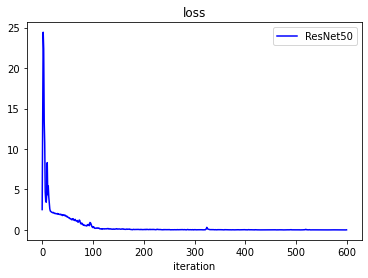

In [65]:
plt.plot(losses, 'b',label='ResNet50')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

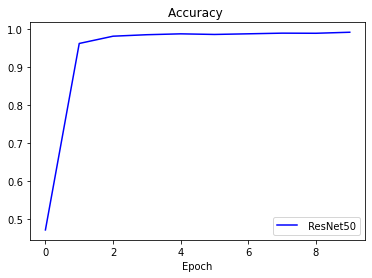

In [27]:
plt.plot(accuracies, 'b',label=' ResNet50')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()